<a href="https://colab.research.google.com/github/doaadoukh/imlo_final/blob/main/imlo_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 17 01:58:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   42C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN model
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 25 * 25, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = x.view(-1, 64 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
num_epochs = 30
learning_rate = 0.001
weight_decay = 0.0001


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_data = datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


model = OptimizedCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


def compute_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    train_accuracy = compute_accuracy(train_loader, model)
    val_accuracy = compute_accuracy(val_loader, model)
    test_accuracy = compute_accuracy(test_loader, model)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")
    print(f'Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/30, Loss: 14.1140
Training Accuracy: 3.14%
Validation Accuracy: 2.16%
Test Accuracy: 1.66%
Epoch 2/30, Loss: 4.6140
Training Accuracy: 1.47%
Validation Accuracy: 1.08%
Test Accuracy: 0.67%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 28 * 28, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = self.dropout(x)
        x = self.fc1(x)
        return x



learning_rate = 0.00005
weight_decay = 1e-2
dropout_rate = 0.7

model = FlowerClassifier(dropout_rate=dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100

        val_accuracy = calculate_accuracy(val_loader, model)
        test_accuracy = calculate_accuracy(test_loader, model)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=100)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)

100%|██████████| 344862509/344862509 [00:25<00:00, 13475120.24it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 798763.51it/s]


100%|██████████| 14989/14989 [00:00<00:00, 21026228.31it/s]


Epoch 0/99, Loss: 0.0757, Train Acc: 1.10%, Val Acc: 0.49%, Test Acc: 3.46%
Epoch 1/99, Loss: 0.0701, Train Acc: 6.13%, Val Acc: 2.45%, Test Acc: 4.73%
Epoch 2/99, Loss: 0.0644, Train Acc: 9.68%, Val Acc: 3.43%, Test Acc: 8.41%
Epoch 3/99, Loss: 0.0582, Train Acc: 15.93%, Val Acc: 10.29%, Test Acc: 13.95%
Epoch 4/99, Loss: 0.0539, Train Acc: 17.77%, Val Acc: 11.76%, Test Acc: 15.63%
Epoch 5/99, Loss: 0.0513, Train Acc: 23.53%, Val Acc: 13.24%, Test Acc: 17.08%
Epoch 6/99, Loss: 0.0493, Train Acc: 25.37%, Val Acc: 16.67%, Test Acc: 19.34%
Epoch 7/99, Loss: 0.0479, Train Acc: 26.96%, Val Acc: 18.63%, Test Acc: 20.46%
Epoch 8/99, Loss: 0.0469, Train Acc: 28.43%, Val Acc: 17.16%, Test Acc: 21.50%
Epoch 9/99, Loss: 0.0462, Train Acc: 28.06%, Val Acc: 13.73%, Test Acc: 22.00%
Epoch 10/99, Loss: 0.0447, Train Acc: 29.90%, Val Acc: 23.04%, Test Acc: 23.21%
Epoch 11/99, Loss: 0.0437, Train Acc: 33.58%, Val Acc: 19.12%, Test Acc: 22.48%
Epoch 12/99, Loss: 0.0424, Train Acc: 32.35%, Val Acc: 19.6

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 28 * 28, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.001
weight_decay = 1e-3
dropout_rate = 0.5


model = FlowerClassifier(dropout_rate=dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100

        val_accuracy = calculate_accuracy(val_loader, model)
        test_accuracy = calculate_accuracy(test_loader, model)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=100)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 0/99, Loss: 0.0923, Train Acc: 0.98%, Val Acc: 1.96%, Test Acc: 4.54%
Epoch 1/99, Loss: 0.0679, Train Acc: 4.04%, Val Acc: 4.90%, Test Acc: 5.51%
Epoch 2/99, Loss: 0.0620, Train Acc: 9.80%, Val Acc: 6.37%, Test Acc: 9.63%
Epoch 3/99, Loss: 0.0581, Train Acc: 11.27%, Val Acc: 4.90%, Test Acc: 11.06%
Epoch 4/99, Loss: 0.0554, Train Acc: 14.46%, Val Acc: 6.86%, Test Acc: 12.64%
Epoch 5/99, Loss: 0.0537, Train Acc: 16.54%, Val Acc: 8.82%, Test Acc: 14.98%
Epoch 6/99, Loss: 0.0525, Train Acc: 19.61%, Val Acc: 6.86%, Test Acc: 14.56%
Epoch 7/99, Loss: 0.0511, Train Acc: 17.03%, Val Acc: 11.27%, Test Acc: 16.21%
Epoch 8/99, Loss: 0.0498, Train Acc: 21.45%, Val Acc: 8.82%, Test Acc: 16.20%
Epoch 9/99, Loss: 0.0500, Train Acc: 21.69%, Val Acc: 10.78%, Test Acc: 16.46%
Epoch 10/99, Loss: 0.0487, Train Acc: 22.67%, Val Acc: 13.73%, Test Acc: 17.16%
Epoch 11/99, Loss: 0.0471, Train Acc: 24.26%, Val Acc: 9.31%, Test Acc: 17.86%
Epoch 12/99, Loss: 0.0474, Train Acc: 21.94%, Val Acc: 16.18%, Te

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

s
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 24 * 24, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 24 * 24)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5


model = FlowerClassifier(dropout_rate=dropout_rate).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=300):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)
        test_accuracy = calculate_accuracy(test_loader, model)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=300)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/300, Loss: 0.1805, Train Acc: 1.96%, Val Acc: 5.88%, Test Acc: 5.94%
Epoch 2/300, Loss: 0.1419, Train Acc: 7.72%, Val Acc: 6.37%, Test Acc: 7.56%
Epoch 3/300, Loss: 0.1209, Train Acc: 8.82%, Val Acc: 5.88%, Test Acc: 8.72%
Epoch 4/300, Loss: 0.0959, Train Acc: 10.91%, Val Acc: 5.39%, Test Acc: 9.14%
Epoch 5/300, Loss: 0.0711, Train Acc: 14.34%, Val Acc: 8.33%, Test Acc: 9.01%
Epoch 6/300, Loss: 0.0574, Train Acc: 14.95%, Val Acc: 12.75%, Test Acc: 13.60%
Epoch 7/300, Loss: 0.0498, Train Acc: 16.91%, Val Acc: 6.37%, Test Acc: 12.00%
Epoch 8/300, Loss: 0.0446, Train Acc: 18.14%, Val Acc: 11.76%, Test Acc: 15.87%
Epoch 9/300, Loss: 0.0406, Train Acc: 23.16%, Val Acc: 11.27%, Test Acc: 13.95%
Epoch 10/300, Loss: 0.0373, Train Acc: 25.25%, Val Acc: 14.71%, Test Acc: 16.93%
Epoch 11/300, Loss: 0.0372, Train Acc: 24.75%, Val Acc: 10.78%, Test Acc: 15.79%
Epoch 12/300, Loss: 0.0318, Train Acc: 29.90%, Val Acc: 16.18%, Test Acc: 18.20%
Epoch 13/300, Loss: 0.0320, Train Acc: 28.92%, Val 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 12 * 12, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 12 * 12)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5

model = FlowerClassifier(dropout_rate=dropout_rate).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):

        batch_size = 64 if epoch < 100 else 32 if epoch < 200 else 16
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)
        test_accuracy = calculate_accuracy(test_loader, model)
        print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=300)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/300, Batch Size: 64, Loss: 0.3513, Train Acc: 1.47%, Val Acc: 0.98%, Test Acc: 2.81%
Epoch 2/300, Batch Size: 64, Loss: 0.2092, Train Acc: 2.70%, Val Acc: 1.47%, Test Acc: 3.84%
Epoch 3/300, Batch Size: 64, Loss: 0.1382, Train Acc: 2.45%, Val Acc: 2.45%, Test Acc: 5.61%
Epoch 4/300, Batch Size: 64, Loss: 0.1132, Train Acc: 4.90%, Val Acc: 2.94%, Test Acc: 3.82%
Epoch 5/300, Batch Size: 64, Loss: 0.1014, Train Acc: 5.02%, Val Acc: 4.90%, Test Acc: 5.98%
Epoch 6/300, Batch Size: 64, Loss: 0.0925, Train Acc: 8.09%, Val Acc: 3.92%, Test Acc: 5.77%
Epoch 7/300, Batch Size: 64, Loss: 0.0875, Train Acc: 7.48%, Val Acc: 5.88%, Test Acc: 7.27%
Epoch 8/300, Batch Size: 64, Loss: 0.0845, Train Acc: 7.60%, Val Acc: 4.90%, Test Acc: 10.90%
Epoch 9/300, Batch Size: 64, Loss: 0.0859, Train Acc: 9.19%, Val Acc: 3.92%, Test Acc: 9.82%
Epoch 10/300, Batch Size: 64, Loss: 0.0812, Train Acc: 7.11%, Val Acc: 3.43%, Test Acc: 7.68%
Epoch 11/300, Batch Size: 64, Loss: 0.0794, Train Acc: 8.95%, Val Ac

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader


batch_size = 64


train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 24 * 24, 102)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 24 * 24)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_dataset, val_dataset, test_dataset, criterion, optimizer, scheduler, num_epochs=300):
    batch_size = 64
    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)

    for epoch in range(num_epochs):

        if epoch == 100:
            batch_size = 128
            train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_dataset, val_dataset, test_dataset, criterion, optimizer, scheduler, num_epochs=300)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

final_train_loader, final_val_loader, final_test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, 128)
evaluate_model(trained_model, final_test_loader)


Exception ignored in: <function _ConnectionBase.__del__ at 0x796b292f88b0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch 1/300, Loss: 0.3231, Train Acc: 3.55%, Val Acc: 2.45%
Epoch 2/300, Loss: 0.2129, Train Acc: 8.09%, Val Acc: 9.31%
Epoch 3/300, Loss: 0.1441, Train Acc: 7.72%, Val Acc: 6.86%
Epoch 4/300, Loss: 0.1196, Train Acc: 12.25%, Val Acc: 7.84%
Epoch 5/300, Loss: 0.0919, Train Acc: 15.32%, Val Acc: 13.24%
Epoch 6/300, Loss: 0.0949, Train Acc: 17.40%, Val Acc: 15.69%
Epoch 7/300, Loss: 0.0843, Train Acc: 22.30%, Val Acc: 12.25%
Epoch 8/300, Loss: 0.0848, Train Acc: 21.20%, Val Acc: 14.71%
Epoch 9/300, Loss: 0.0825, Train Acc: 20.10%, Val Acc: 12.75%
Epoch 10/300, Loss: 0.0814, Train Acc: 24.02%, Val Acc: 10.29%
Epoch 11/300, Loss: 0.0725, Train Acc: 25.98%, Val Acc: 12.25%
Epoch 12/300, Loss: 0.0693, Train Acc: 30.64%, Val Acc: 19.12%
Epoch 13/300, Loss: 0.0734, Train Acc: 29.53%, Val Acc: 23.04%
Epoch 14/300, Loss: 0.0667, Train Acc: 30.64%, Val Acc: 16.18%
Epoch 15/300, Loss: 0.0658, Train Acc: 30.15%, Val Acc: 20.59%
Epoch 16/300, Loss: 0.0669, Train Acc: 33.33%, Val Acc: 15.20%
Epoch 17

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


initial_batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=initial_batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=initial_batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=initial_batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 12 * 12, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 12 * 12)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=500):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):

        if epoch < 100:
            batch_size = 64
        elif epoch < 200:
            batch_size = 32
        elif epoch < 300:
            batch_size = 64
        else:
            batch_size = 128

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)
        print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=500)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/500, Batch Size: 64, Loss: 0.3639, Train Acc: 2.21%, Val Acc: 1.47%
Epoch 2/500, Batch Size: 64, Loss: 0.1867, Train Acc: 2.82%, Val Acc: 2.94%
Epoch 3/500, Batch Size: 64, Loss: 0.1438, Train Acc: 3.80%, Val Acc: 3.92%
Epoch 4/500, Batch Size: 64, Loss: 0.1168, Train Acc: 3.19%, Val Acc: 5.88%
Epoch 5/500, Batch Size: 64, Loss: 0.1027, Train Acc: 4.17%, Val Acc: 4.41%
Epoch 6/500, Batch Size: 64, Loss: 0.0877, Train Acc: 4.78%, Val Acc: 6.37%
Epoch 7/500, Batch Size: 64, Loss: 0.0858, Train Acc: 4.90%, Val Acc: 4.90%
Epoch 8/500, Batch Size: 64, Loss: 0.0830, Train Acc: 4.66%, Val Acc: 4.41%
Epoch 9/500, Batch Size: 64, Loss: 0.0798, Train Acc: 7.11%, Val Acc: 6.37%
Epoch 10/500, Batch Size: 64, Loss: 0.0817, Train Acc: 6.74%, Val Acc: 3.92%
Epoch 11/500, Batch Size: 64, Loss: 0.0746, Train Acc: 9.56%, Val Acc: 5.88%
Epoch 12/500, Batch Size: 64, Loss: 0.0734, Train Acc: 9.07%, Val Acc: 5.88%
Epoch 13/500, Batch Size: 64, Loss: 0.0740, Train Acc: 9.31%, Val Acc: 5.88%
Epoch 14

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 12 * 12, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 12 * 12)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5


model = FlowerClassifier(dropout_rate=dropout_rate).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):

        batch_size = 64 if epoch < 100 else 32 if epoch < 200 else 16
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)
        test_accuracy = calculate_accuracy(test_loader, model)
        print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_dataset, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=500)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/500, Batch Size: 64, Loss: 0.3478, Train Acc: 1.35%, Val Acc: 3.92%
Epoch 2/500, Batch Size: 64, Loss: 0.2110, Train Acc: 2.57%, Val Acc: 1.96%
Epoch 3/500, Batch Size: 64, Loss: 0.1541, Train Acc: 3.31%, Val Acc: 1.96%
Epoch 4/500, Batch Size: 64, Loss: 0.1222, Train Acc: 4.17%, Val Acc: 2.45%
Epoch 5/500, Batch Size: 64, Loss: 0.0952, Train Acc: 4.90%, Val Acc: 4.41%
Epoch 6/500, Batch Size: 64, Loss: 0.0878, Train Acc: 6.25%, Val Acc: 3.43%
Epoch 7/500, Batch Size: 64, Loss: 0.0841, Train Acc: 5.64%, Val Acc: 7.35%
Epoch 8/500, Batch Size: 64, Loss: 0.0765, Train Acc: 9.31%, Val Acc: 6.37%
Epoch 9/500, Batch Size: 64, Loss: 0.0809, Train Acc: 6.62%, Val Acc: 4.41%
Epoch 10/500, Batch Size: 64, Loss: 0.0767, Train Acc: 8.21%, Val Acc: 7.35%
Epoch 11/500, Batch Size: 64, Loss: 0.0800, Train Acc: 7.84%, Val Acc: 3.92%
Epoch 12/500, Batch Size: 64, Loss: 0.0742, Train Acc: 9.93%, Val Acc: 5.39%
Epoch 13/500, Batch Size: 64, Loss: 0.0705, Train Acc: 11.03%, Val Acc: 6.37%
Epoch 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 12 * 12, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 12 * 12)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

learning_rate = 0.001
weight_decay = 0.01
dropout_rate = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)



        print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/1000, Batch Size: 64, Loss: 0.6909, Train Acc: 1.10%, Val Acc: 2.94%
Epoch 2/1000, Batch Size: 64, Loss: 0.4310, Train Acc: 1.84%, Val Acc: 1.96%
Epoch 3/1000, Batch Size: 64, Loss: 0.3617, Train Acc: 1.59%, Val Acc: 2.94%
Epoch 4/1000, Batch Size: 64, Loss: 0.3304, Train Acc: 1.84%, Val Acc: 5.39%
Epoch 5/1000, Batch Size: 64, Loss: 0.2490, Train Acc: 2.08%, Val Acc: 2.94%
Epoch 6/1000, Batch Size: 64, Loss: 0.1594, Train Acc: 3.80%, Val Acc: 4.41%
Epoch 7/1000, Batch Size: 64, Loss: 0.1134, Train Acc: 3.80%, Val Acc: 2.45%
Epoch 8/1000, Batch Size: 64, Loss: 0.0936, Train Acc: 4.53%, Val Acc: 1.96%
Epoch 9/1000, Batch Size: 64, Loss: 0.0847, Train Acc: 5.15%, Val Acc: 3.43%
Epoch 10/1000, Batch Size: 64, Loss: 0.0811, Train Acc: 6.00%, Val Acc: 5.88%
Epoch 11/1000, Batch Size: 64, Loss: 0.0758, Train Acc: 6.86%, Val Acc: 3.43%
Epoch 12/1000, Batch Size: 64, Loss: 0.0734, Train Acc: 8.58%, Val Acc: 7.84%
Epoch 13/1000, Batch Size: 64, Loss: 0.0725, Train Acc: 6.86%, Val Acc: 9

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


learning_rate = 0.0005
weight_decay = 0.001
dropout_rate = 0.5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
              for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)
              return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)


        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)



Epoch 1/1000, Batch Size: 64, Loss: 0.4323, Train Acc: 1.10%, Val Acc: 2.45%
Epoch 11/1000, Batch Size: 64, Loss: 0.0919, Train Acc: 2.21%, Val Acc: 2.94%
Epoch 21/1000, Batch Size: 64, Loss: 0.0689, Train Acc: 10.66%, Val Acc: 7.35%
Epoch 31/1000, Batch Size: 64, Loss: 0.0681, Train Acc: 11.76%, Val Acc: 7.35%
Epoch 41/1000, Batch Size: 64, Loss: 0.0628, Train Acc: 14.83%, Val Acc: 9.31%
Epoch 51/1000, Batch Size: 64, Loss: 0.0589, Train Acc: 17.65%, Val Acc: 11.76%
Epoch 61/1000, Batch Size: 64, Loss: 0.0462, Train Acc: 29.17%, Val Acc: 19.12%
Epoch 71/1000, Batch Size: 64, Loss: 0.0517, Train Acc: 23.16%, Val Acc: 11.76%
Epoch 81/1000, Batch Size: 64, Loss: 0.0501, Train Acc: 24.75%, Val Acc: 17.65%
Epoch 91/1000, Batch Size: 64, Loss: 0.0477, Train Acc: 26.72%, Val Acc: 18.14%
Epoch 101/1000, Batch Size: 64, Loss: 0.0449, Train Acc: 30.88%, Val Acc: 20.10%
Epoch 111/1000, Batch Size: 64, Loss: 0.0410, Train Acc: 33.58%, Val Acc: 17.16%
Epoch 121/1000, Batch Size: 64, Loss: 0.0375, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

learning_rate = 0.0005
weight_decay = 0.001
dropout_rate = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/2000, Batch Size: 64, Loss: 0.3812, Train Acc: 2.21%, Val Acc: 2.94%
Epoch 51/2000, Batch Size: 64, Loss: 0.0516, Train Acc: 20.83%, Val Acc: 13.24%
Epoch 101/2000, Batch Size: 64, Loss: 0.0427, Train Acc: 33.82%, Val Acc: 16.18%
Epoch 151/2000, Batch Size: 64, Loss: 0.0416, Train Acc: 36.03%, Val Acc: 19.12%
Epoch 201/2000, Batch Size: 64, Loss: 0.0333, Train Acc: 47.06%, Val Acc: 20.10%
Epoch 251/2000, Batch Size: 64, Loss: 0.0226, Train Acc: 62.50%, Val Acc: 23.53%
Epoch 301/2000, Batch Size: 64, Loss: 0.0187, Train Acc: 68.14%, Val Acc: 29.41%
Epoch 351/2000, Batch Size: 64, Loss: 0.0247, Train Acc: 60.17%, Val Acc: 26.47%
Epoch 401/2000, Batch Size: 64, Loss: 0.0225, Train Acc: 64.95%, Val Acc: 27.94%
Epoch 451/2000, Batch Size: 64, Loss: 0.0163, Train Acc: 71.57%, Val Acc: 25.49%
Epoch 501/2000, Batch Size: 64, Loss: 0.0145, Train Acc: 76.72%, Val Acc: 32.35%
Epoch 551/2000, Batch Size: 64, Loss: 0.0104, Train Acc: 82.23%, Val Acc: 37.75%
Epoch 601/2000, Batch Size: 64, L

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0005
weight_decay = 0.001
dropout_rate = 0.5
num_epochs = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:  # Print every 50 epochs to save time
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

# Train the model
trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/1000, Batch Size: 64, Loss: 0.4560, Train Acc: 0.86%, Val Acc: 0.98%
Epoch 51/1000, Batch Size: 64, Loss: 0.0714, Train Acc: 1.84%, Val Acc: 0.00%
Epoch 101/1000, Batch Size: 64, Loss: 0.0691, Train Acc: 1.72%, Val Acc: 0.98%
Epoch 151/1000, Batch Size: 64, Loss: 0.0690, Train Acc: 1.96%, Val Acc: 1.47%
Epoch 201/1000, Batch Size: 64, Loss: 0.0683, Train Acc: 2.08%, Val Acc: 0.49%
Epoch 251/1000, Batch Size: 64, Loss: 0.0672, Train Acc: 2.57%, Val Acc: 0.98%
Epoch 301/1000, Batch Size: 64, Loss: 0.0651, Train Acc: 3.80%, Val Acc: 2.45%
Epoch 351/1000, Batch Size: 64, Loss: 0.0662, Train Acc: 4.29%, Val Acc: 1.47%
Epoch 401/1000, Batch Size: 64, Loss: 0.0635, Train Acc: 5.76%, Val Acc: 1.47%
Epoch 451/1000, Batch Size: 64, Loss: 0.0595, Train Acc: 9.19%, Val Acc: 4.41%
Epoch 501/1000, Batch Size: 64, Loss: 0.0537, Train Acc: 16.42%, Val Acc: 10.78%
Epoch 551/1000, Batch Size: 64, Loss: 0.0493, Train Acc: 21.20%, Val Acc: 15.69%
Epoch 601/1000, Batch Size: 64, Loss: 0.0475, Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0005
weight_decay = 0.001
dropout_rate = 0.5
num_epochs = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


100%|██████████| 344862509/344862509 [00:25<00:00, 13442959.56it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 672911.67it/s]


100%|██████████| 14989/14989 [00:00<00:00, 20572127.83it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2000, Batch Size: 64, Loss: 0.4863, Train Acc: 1.72%, Val Acc: 2.45%
Epoch 51/2000, Batch Size: 64, Loss: 0.0736, Train Acc: 1.10%, Val Acc: 0.00%
Epoch 101/2000, Batch Size: 64, Loss: 0.0735, Train Acc: 1.23%, Val Acc: 0.00%
Epoch 151/2000, Batch Size: 64, Loss: 0.0718, Train Acc: 1.47%, Val Acc: 0.49%
Epoch 201/2000, Batch Size: 64, Loss: 0.0712, Train Acc: 2.08%, Val Acc: 0.49%
Epoch 251/2000, Batch Size: 64, Loss: 0.0693, Train Acc: 2.94%, Val Acc: 0.49%
Epoch 301/2000, Batch Size: 64, Loss: 0.0685, Train Acc: 1.47%, Val Acc: 1.47%
Epoch 351/2000, Batch Size: 64, Loss: 0.0691, Train Acc: 2.70%, Val Acc: 0.98%
Epoch 401/2000, Batch Size: 64, Loss: 0.0677, Train Acc: 3.43%, Val Acc: 2.45%
Epoch 451/2000, Batch Size: 64, Loss: 0.0615, Train Acc: 6.62%, Val Acc: 4.41%
Epoch 501/2000, Batch Size: 64, Loss: 0.0556, Train Acc: 15.32%, Val Acc: 11.76%
Epoch 551/2000, Batch Size: 64, Loss: 0.0510, Train Acc: 19.12%, Val Acc: 17.65%
Epoch 601/2000, Batch Size: 64, Loss: 0.0476, Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 2048)
        self.fc2 = nn.Linear(2048, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


learning_rate = 0.0001
weight_decay = 0.0005
dropout_rate = 0.6
num_epochs = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model


trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


Epoch 1/2000, Batch Size: 64, Loss: 0.1311, Train Acc: 1.23%, Val Acc: 2.94%
Epoch 51/2000, Batch Size: 64, Loss: 0.0654, Train Acc: 6.86%, Val Acc: 5.88%
Epoch 101/2000, Batch Size: 64, Loss: 0.0593, Train Acc: 11.15%, Val Acc: 5.88%
Epoch 151/2000, Batch Size: 64, Loss: 0.0580, Train Acc: 12.75%, Val Acc: 9.80%
Epoch 201/2000, Batch Size: 64, Loss: 0.0543, Train Acc: 16.42%, Val Acc: 13.73%
Epoch 251/2000, Batch Size: 64, Loss: 0.0509, Train Acc: 19.98%, Val Acc: 19.61%
Epoch 301/2000, Batch Size: 64, Loss: 0.0502, Train Acc: 19.85%, Val Acc: 19.61%
Epoch 351/2000, Batch Size: 64, Loss: 0.0507, Train Acc: 18.63%, Val Acc: 18.14%
Epoch 401/2000, Batch Size: 64, Loss: 0.0486, Train Acc: 20.83%, Val Acc: 23.04%
Epoch 451/2000, Batch Size: 64, Loss: 0.0471, Train Acc: 23.16%, Val Acc: 24.02%
Epoch 501/2000, Batch Size: 64, Loss: 0.0434, Train Acc: 29.78%, Val Acc: 23.04%
Epoch 551/2000, Batch Size: 64, Loss: 0.0410, Train Acc: 32.60%, Val Acc: 23.04%
Epoch 601/2000, Batch Size: 64, Loss:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5
num_epochs = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


100%|██████████| 344862509/344862509 [00:16<00:00, 21024184.88it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 797251.27it/s]


100%|██████████| 14989/14989 [00:00<00:00, 17669596.02it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2000, Batch Size: 64, Loss: 0.4107, Train Acc: 1.47%, Val Acc: 0.49%
Epoch 51/2000, Batch Size: 64, Loss: 0.0694, Train Acc: 1.96%, Val Acc: 0.98%
Epoch 101/2000, Batch Size: 64, Loss: 0.0682, Train Acc: 1.23%, Val Acc: 0.98%
Epoch 151/2000, Batch Size: 64, Loss: 0.0665, Train Acc: 3.06%, Val Acc: 1.96%
Epoch 201/2000, Batch Size: 64, Loss: 0.0605, Train Acc: 7.72%, Val Acc: 5.39%
Epoch 251/2000, Batch Size: 64, Loss: 0.0542, Train Acc: 14.09%, Val Acc: 10.78%
Epoch 301/2000, Batch Size: 64, Loss: 0.0487, Train Acc: 22.55%, Val Acc: 20.59%
Epoch 351/2000, Batch Size: 64, Loss: 0.0514, Train Acc: 18.50%, Val Acc: 12.25%
Epoch 401/2000, Batch Size: 64, Loss: 0.0460, Train Acc: 27.21%, Val Acc: 20.59%
Epoch 451/2000, Batch Size: 64, Loss: 0.0407, Train Acc: 35.05%, Val Acc: 24.02%
Epoch 501/2000, Batch Size: 64, Loss: 0.0342, Train Acc: 44.00%, Val Acc: 26.47%
Epoch 551/2000, Batch Size: 64, Loss: 0.0309, Train Acc: 51.23%, Val Acc: 37.25%
Epoch 601/2000, Batch Size: 64, Loss: 0.0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0001
weight_decay = 0.0005
dropout_rate = 0.6
num_epochs = 1500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1)

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=1500):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')


evaluate_model(trained_model, test_loader)


100%|██████████| 344862509/344862509 [00:24<00:00, 14066325.24it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1477572.36it/s]


100%|██████████| 14989/14989 [00:00<00:00, 20741808.86it/s]


Epoch 1/1500, Batch Size: 32, Loss: 0.2139, Train Acc: 1.35%, Val Acc: 1.47%
Epoch 51/1500, Batch Size: 32, Loss: 0.1406, Train Acc: 2.08%, Val Acc: 0.49%
Epoch 101/1500, Batch Size: 32, Loss: 0.1375, Train Acc: 2.45%, Val Acc: 3.92%
Epoch 151/1500, Batch Size: 32, Loss: 0.1373, Train Acc: 2.33%, Val Acc: 2.45%
Epoch 201/1500, Batch Size: 32, Loss: 0.1344, Train Acc: 3.55%, Val Acc: 2.45%
Epoch 251/1500, Batch Size: 32, Loss: 0.1286, Train Acc: 3.43%, Val Acc: 4.90%
Epoch 301/1500, Batch Size: 32, Loss: 0.1246, Train Acc: 6.00%, Val Acc: 5.88%
Epoch 351/1500, Batch Size: 32, Loss: 0.1200, Train Acc: 8.82%, Val Acc: 6.37%
Epoch 401/1500, Batch Size: 32, Loss: 0.1149, Train Acc: 10.54%, Val Acc: 6.37%
Epoch 451/1500, Batch Size: 32, Loss: 0.1102, Train Acc: 13.24%, Val Acc: 12.25%
Epoch 501/1500, Batch Size: 32, Loss: 0.1054, Train Acc: 16.05%, Val Acc: 13.24%
Epoch 551/1500, Batch Size: 32, Loss: 0.1019, Train Acc: 15.44%, Val Acc: 18.63%
Epoch 601/1500, Batch Size: 32, Loss: 0.0971, Tr

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0001
weight_decay = 0.0005
dropout_rate = 0.6
num_epochs = 2000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    model.load_state_dict(torch.load('best_model.pth'))
    return model


trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


100%|██████████| 344862509/344862509 [00:23<00:00, 14419904.67it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 812009.49it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13667048.40it/s]


Epoch 1/2000, Batch Size: 32, Loss: 0.2014, Train Acc: 1.96%, Val Acc: 2.94%
Epoch 51/2000, Batch Size: 32, Loss: 0.1389, Train Acc: 2.57%, Val Acc: 0.49%
Epoch 101/2000, Batch Size: 32, Loss: 0.1358, Train Acc: 3.19%, Val Acc: 1.47%
Epoch 151/2000, Batch Size: 32, Loss: 0.1337, Train Acc: 3.31%, Val Acc: 1.47%
Epoch 201/2000, Batch Size: 32, Loss: 0.1318, Train Acc: 5.39%, Val Acc: 4.41%
Epoch 251/2000, Batch Size: 32, Loss: 0.1238, Train Acc: 5.15%, Val Acc: 3.92%
Epoch 301/2000, Batch Size: 32, Loss: 0.1206, Train Acc: 8.46%, Val Acc: 7.35%
Epoch 351/2000, Batch Size: 32, Loss: 0.1153, Train Acc: 10.54%, Val Acc: 8.33%
Epoch 401/2000, Batch Size: 32, Loss: 0.1094, Train Acc: 14.34%, Val Acc: 8.82%
Epoch 451/2000, Batch Size: 32, Loss: 0.1090, Train Acc: 13.73%, Val Acc: 11.27%
Epoch 501/2000, Batch Size: 32, Loss: 0.1042, Train Acc: 17.40%, Val Acc: 13.73%
Epoch 551/2000, Batch Size: 32, Loss: 0.1001, Train Acc: 20.59%, Val Acc: 17.16%
Epoch 601/2000, Batch Size: 32, Loss: 0.0981, T

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)

dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5
num_epochs = 2000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100


def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    model.load_state_dict(torch.load('best_model.pth'))
    return model


trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')


evaluate_model(trained_model, test_loader)


Epoch 1/2000, Batch Size: 64, Loss: 0.3428, Train Acc: 0.86%, Val Acc: 1.96%
Epoch 51/2000, Batch Size: 64, Loss: 0.0697, Train Acc: 1.23%, Val Acc: 0.49%
Epoch 101/2000, Batch Size: 64, Loss: 0.0694, Train Acc: 1.59%, Val Acc: 1.96%
Epoch 151/2000, Batch Size: 64, Loss: 0.0686, Train Acc: 2.33%, Val Acc: 2.94%
Epoch 201/2000, Batch Size: 64, Loss: 0.0600, Train Acc: 9.19%, Val Acc: 6.86%
Epoch 251/2000, Batch Size: 64, Loss: 0.0530, Train Acc: 17.65%, Val Acc: 9.80%
Epoch 301/2000, Batch Size: 64, Loss: 0.0477, Train Acc: 24.14%, Val Acc: 19.12%
Epoch 351/2000, Batch Size: 64, Loss: 0.0519, Train Acc: 20.47%, Val Acc: 12.75%
Epoch 401/2000, Batch Size: 64, Loss: 0.0469, Train Acc: 24.75%, Val Acc: 19.61%
Epoch 451/2000, Batch Size: 64, Loss: 0.0389, Train Acc: 35.42%, Val Acc: 29.90%
Epoch 501/2000, Batch Size: 64, Loss: 0.0347, Train Acc: 44.36%, Val Acc: 33.82%
Epoch 551/2000, Batch Size: 64, Loss: 0.0304, Train Acc: 50.25%, Val Acc: 40.69%
Epoch 601/2000, Batch Size: 64, Loss: 0.02

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


flowers102_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform=test_transform)


dataset_size = len(flowers102_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(flowers102_dataset, [train_size, val_size])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class FlowerClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


learning_rate = 0.0005
weight_decay = 0.01
dropout_rate = 0.5
num_epochs = 2000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerClassifier(dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    return (correct.double() / total) * 100

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=2000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct.double() / total) * 100
        val_accuracy = calculate_accuracy(val_loader, model)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch Size: {batch_size}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    print('Training complete')
    model.load_state_dict(torch.load('best_model.pth'))
    return model

trained_model = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)


def evaluate_model(model, test_loader):
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(trained_model, test_loader)


100%|██████████| 344862509/344862509 [00:23<00:00, 14530798.57it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 783602.76it/s]


100%|██████████| 14989/14989 [00:00<00:00, 20240960.29it/s]


Epoch 1/2000, Batch Size: 64, Loss: 0.3224, Train Acc: 0.86%, Val Acc: 0.49%
Epoch 51/2000, Batch Size: 64, Loss: 0.0681, Train Acc: 2.82%, Val Acc: 1.96%
Epoch 101/2000, Batch Size: 64, Loss: 0.0665, Train Acc: 4.53%, Val Acc: 3.92%
Epoch 151/2000, Batch Size: 64, Loss: 0.0632, Train Acc: 5.88%, Val Acc: 2.45%
Epoch 201/2000, Batch Size: 64, Loss: 0.0596, Train Acc: 11.89%, Val Acc: 10.29%
Epoch 251/2000, Batch Size: 64, Loss: 0.0524, Train Acc: 19.49%, Val Acc: 13.24%
Epoch 301/2000, Batch Size: 64, Loss: 0.0469, Train Acc: 26.72%, Val Acc: 20.59%
Epoch 351/2000, Batch Size: 64, Loss: 0.0495, Train Acc: 19.12%, Val Acc: 15.69%
Epoch 401/2000, Batch Size: 64, Loss: 0.0458, Train Acc: 25.37%, Val Acc: 21.08%
Epoch 451/2000, Batch Size: 64, Loss: 0.0404, Train Acc: 34.68%, Val Acc: 23.04%
Epoch 501/2000, Batch Size: 64, Loss: 0.0340, Train Acc: 45.22%, Val Acc: 30.88%
Epoch 551/2000, Batch Size: 64, Loss: 0.0293, Train Acc: 51.84%, Val Acc: 37.25%
Epoch 601/2000, Batch Size: 64, Loss: 0

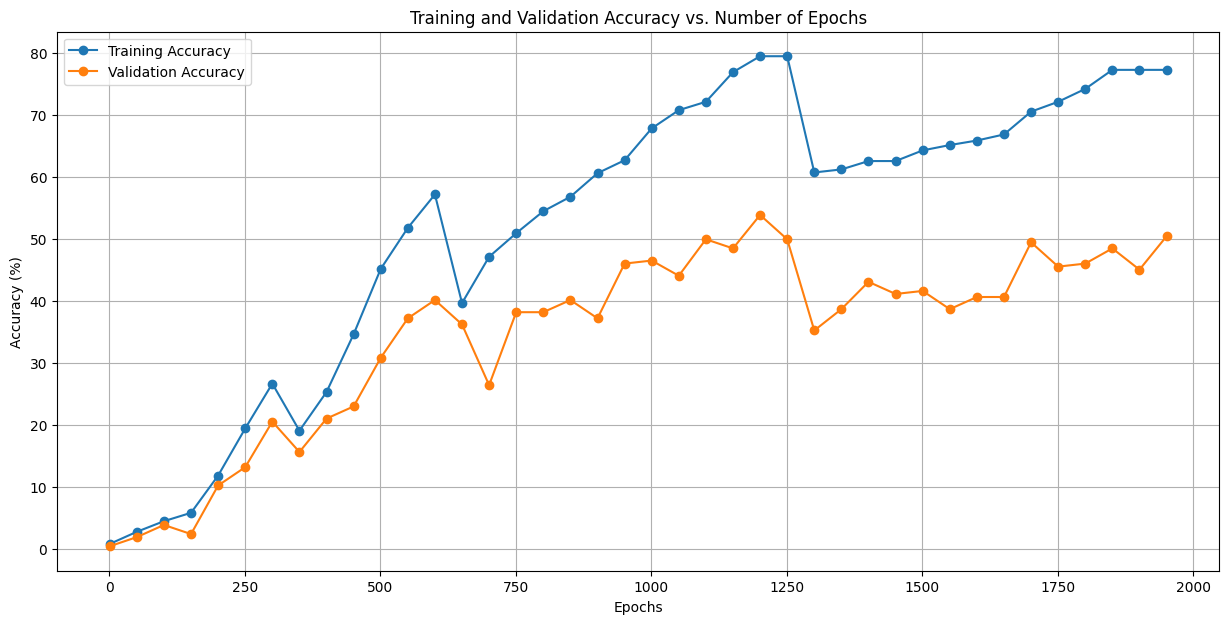

In [ ]:
import matplotlib.pyplot as  plt


epochs = list(range(1, 2001, 50))


training_accuracy = [0.86, 2.82, 4.53, 5.88, 11.89, 19.49, 26.72, 19.12, 25.37, 34.68,
                     45.22, 51.84, 57.23, 39.71, 47.18, 50.98, 54.53, 56.86, 60.66, 62.75,
                     67.89, 70.83, 72.18, 76.96, 79.53, 79.53, 60.78, 61.27, 62.62, 62.62,
                     64.34, 65.20, 65.93, 66.91, 70.59, 72.18, 74.26, 77.33, 77.33, 77.33]
validation_accuracy = [0.49, 1.96, 3.92, 2.45, 10.29, 13.24, 20.59, 15.69, 21.08, 23.04,
                       30.88, 37.25, 40.20, 36.27, 26.47, 38.24, 38.24, 40.20, 37.25, 46.08,
                       46.57, 44.12, 50.00, 48.53, 53.92, 50.00, 35.29, 38.73, 43.14, 41.18,
                       41.67, 38.73, 40.69, 40.69, 49.51, 45.59, 46.08, 48.53, 45.10, 50.49]
plt.figure(figsize=(15, 7))
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()
